In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import torch
import torchaudio

In [6]:
print(torch.__version__)
print(torchaudio.__version__)

2.4.1+cu121
2.4.1+cu121


In [7]:
torch.random.manual_seed(0)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(device)

cuda


In [8]:
import matplotlib.pyplot as plt
import IPython 
from torchaudio.utils import download_asset
speech_file=download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 18.8MB/s]


In [9]:
speech_file

'/root/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'

In [11]:
bundle=torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate",bundle.sample_rate)
print("Labels:",bundle.get_labels())

Sample Rate 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [12]:
model=bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:00<00:00, 466MB/s] 


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [13]:
IPython.display.Audio(speech_file)

In [14]:
waveform,sample_rate=torchaudio.load(speech_file)
waveform=waveform.to(device)
if sample_rate!=bundle.sample_rate:
    waveform=torchaudio.functional.resample(waveform,sample_rate,bundle.sample_rate)
    

In [20]:
with torch.inference_mode():
    features,_= model.extract_features(waveform)

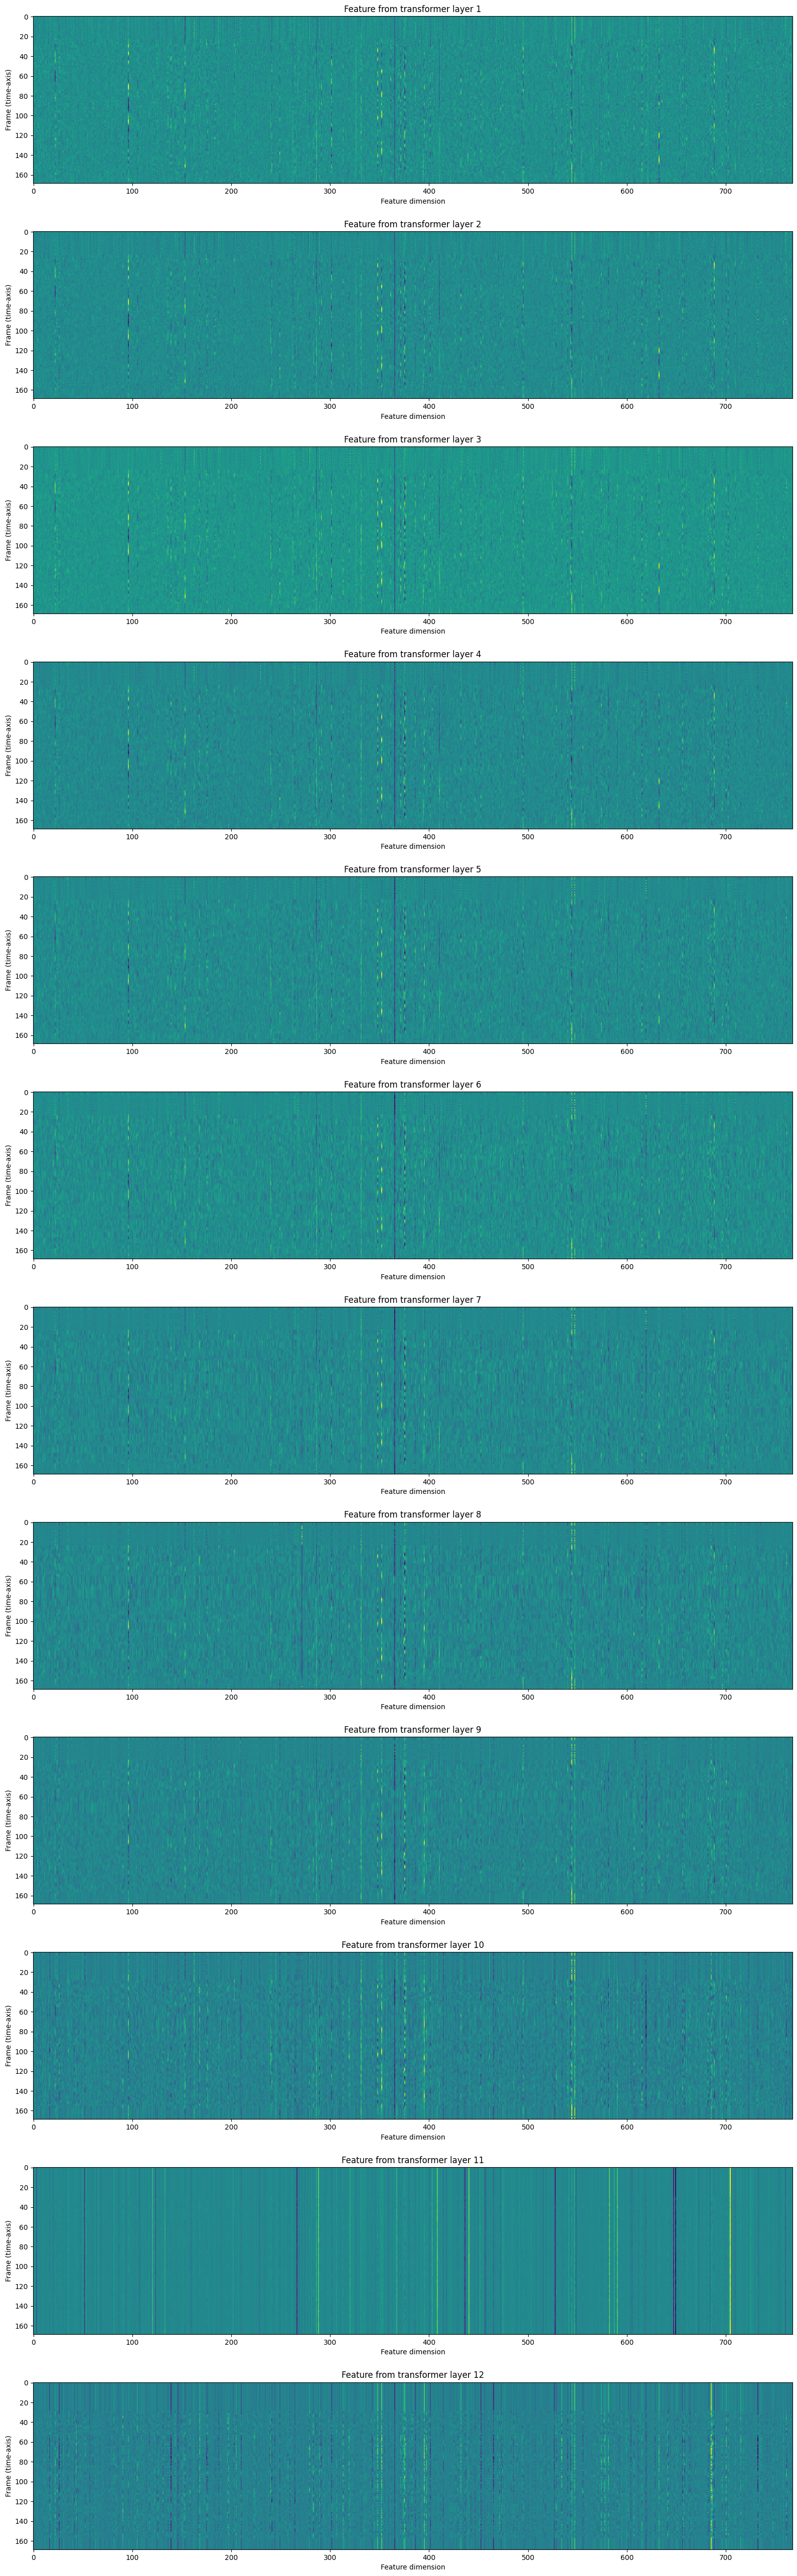

In [21]:
fig,ax=plt.subplots(len(features),1,figsize=(16,4.3*len(features)))
for i,feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(),interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()    

In [22]:
with torch.inference_mode():
    emission,_=model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


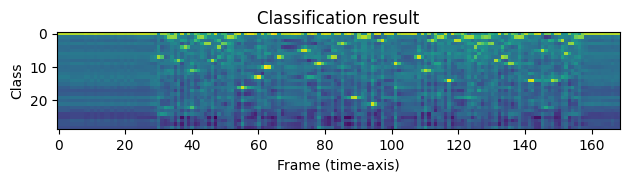

In [23]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [24]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self,labels,blank=0):
        super().__init__()
        self.labels=labels
        self.blank=blank

    def forward(self,emission:torch.Tensor) ->str:
        indices=torch.argmax(emission,dim=-1)
        indices=torch.unique_consecutive(indices,dim=-1)
        indices=[i for i in indices if i!=self.blank]
        return "".join([self.labels[i] for i in indices])
        
    

In [25]:
decoder=GreedyCTCDecoder(labels=bundle.get_labels())
transcript=decoder(emission[0])

In [26]:
print(transcript)
IPython.display.Audio(speech_file)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [28]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveform, ...)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same